# Set-up

This notebook contains a demo on using network analysis for fraud applications.
Dependencies can be installed with  [uv](https://docs.astral.sh/uv/getting-started/):

1. Following the [official instructions](https://docs.astral.sh/uv/getting-started/installation/) to install uv, e.g. using `pipx`: \
```pipx install uv```
2. Navigate to the project folder and create the virtual environment: 
    ```
    cd <path_to_project>
    uv venv
    uv pip install .
    ```
3. Select the kernel of the newly created venv in this notebook. The path is normally something like `<path_to_roject>/.venv/bin/python`

# Imports

In order to use the Kaggle API, you need to have an account.
You can store your credentials in 2 ways:

1. Go to your Kaggle account settings (kaggle.com → Account → API → Create New API Token) and store the downloaded json file in the `.kaggle` folder: `~/.kaggle/kaggle.json` or `C:\Users\<username>\.kaggle\kaggle.json` on Windows. Make sure the permissions are set correctly (not applicable to Windows): `chmod 600 ~/.kaggle/kaggle.json`
2. Alternatively, the credentials in the json file can also be stored as environment variables:
    ```
    os.environ['KAGGLE_USERNAME'] = 'your_username'
    os.environ['KAGGLE_KEY'] = 'your_api_key'
    ```

Instead of using the Kaggle API, you can also download the dataset manually (see link below). Note that if you do not set the Kaggle credentials, you will get an error when trying to run `import kaggle`, you can simply remove this dependency in that case as we only need it to access the data.

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import networkx.algorithms.community as nx_comm

from pyvis.network import Network


# Dataset

We will use the `Bitcoin OTC trust weighted signed network` dataset available from SNAP (Stanford).
This is who-trusts-whom network of people who trade using Bitcoin on a platform called Bitcoin OTC. Since Bitcoin users are anonymous, there is a need to maintain a record of users' reputation to prevent transactions with fraudulent and risky users. Members of Bitcoin OTC rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1. This is the first explicit weighted signed directed network available for research.

For more information on the dataset, please consult the [SNAP (Stanford) website](https://snap.stanford.edu/data/soc-sign-bitcoinotc.html)

In [38]:
# The direct URL to the compressed CSV file on the SNAP website
url = "https://snap.stanford.edu/data/soc-sign-bitcoinotc.csv.gz"

# Column names as described on the SNAP page
column_names = ['SOURCE', 'TARGET', 'RATING', 'TIME']

print(f"Downloading and loading data from {url}...")

# pandas can read a gzipped file directly from a URL
df = pd.read_csv(url, header=None, names=column_names)

print("Download and loading complete. First 5 rows:")
print(df.head())

Download and loading complete. First 5 rows:
   SOURCE  TARGET  RATING          TIME
0       6       2       4  1.289242e+09
1       6       5       2  1.289242e+09
2       1      15       1  1.289243e+09
3       4       3       7  1.289245e+09
4      13      16       8  1.289254e+09


Rating distribution


<Axes: >

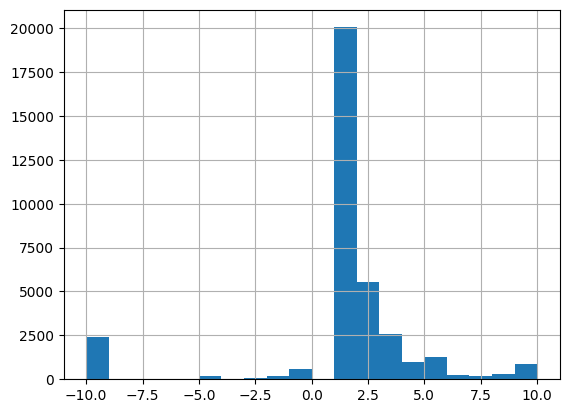

In [40]:
print("Rating distribution")
df['RATING'].hist(bins=20)

# Analysis

## Build network

### Main network

In [41]:
# Create a directed graph from the transactions DataFrame
G = nx.from_pandas_edgelist(
    df,
    source='SOURCE',
    target='TARGET',
    edge_attr=['RATING'], # These columns become edge attributes
    create_using=nx.DiGraph() # Specify a directed graph
) 

print(f"\nGraph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph created with 5881 nodes and 35592 edges.


In [42]:
# Display a few edges with their attributes
print("\nSample edges with attributes:")
for i, (u, v, attrs) in enumerate(list(G.edges(data=True))):
    if i < 3: # Print first 3 edges
        print(f"Edge: ({u}) -> ({v}), Attributes: {attrs}")
    else:
        break


Sample edges with attributes:
Edge: (6) -> (2), Attributes: {'RATING': 4}
Edge: (6) -> (5), Attributes: {'RATING': 2}
Edge: (6) -> (4), Attributes: {'RATING': 2}


In [89]:
# Add 'is_involved_in_fraud' node attribute
fraudulent_transactions_df = df[df['RATING'] < 0]  # Assuming negative ratings indicate fraudulent transactions
nodes_in_fraudulent_transactions = set(fraudulent_transactions_df['SOURCE']).union(set(fraudulent_transactions_df['TARGET']))
node_fraud_involvement = {node: (node in nodes_in_fraudulent_transactions) for node in G.nodes()}
nx.set_node_attributes(G, node_fraud_involvement, 'is_involved_in_fraud')
print("\n'is_involved_in_fraud' attribute added to nodes.")

# Verify for a few nodes
print("\nSample nodes with 'is_involved_in_fraud' attribute:")
involved_count = 0
not_involved_count = 0
for i, node_id in enumerate(list(G.nodes())):
    if G.nodes[node_id].get('is_involved_in_fraud') and involved_count < 2:
        print(f"Node: {node_id}, Attributes: {G.nodes[node_id]}")
        involved_count +=1
    elif not G.nodes[node_id].get('is_involved_in_fraud') and not_involved_count < 2 :
        print(f"Node: {node_id}, Attributes: {G.nodes[node_id]}")
        not_involved_count +=1
    if involved_count >=2 and not_involved_count >=2:
        break


'is_involved_in_fraud' attribute added to nodes.

Sample nodes with 'is_involved_in_fraud' attribute:
Node: 6, Attributes: {'is_involved_in_fraud': True, 'in_degree': 44, 'out_degree': 40, 'betweenness_centrality': 0.002562117925946858, 'closeness_centrality': 0.2960633375202739, 'size': 10, 'title': '\n    <b>node: 6</b><br>\n    --------------------<br>\n    <b>In-Degree:</b> 44<br>\n    <b>Out-Degree:</b> 40<br>\n    <b>Is involved in fraud:</b> True<br>\n    ', 'color': '#ff0000'}
Node: 2, Attributes: {'is_involved_in_fraud': True, 'in_degree': 41, 'out_degree': 45, 'betweenness_centrality': 0.002006417338527687, 'closeness_centrality': 0.26550582111721266, 'size': 10, 'title': '\n    <b>node: 2</b><br>\n    --------------------<br>\n    <b>In-Degree:</b> 41<br>\n    <b>Out-Degree:</b> 45<br>\n    <b>Is involved in fraud:</b> True<br>\n    ', 'color': '#ff0000'}
Node: 5, Attributes: {'is_involved_in_fraud': False, 'in_degree': 3, 'out_degree': 3, 'betweenness_centrality': 0.0, 'cl

### Subset (for faster calculation)

For both visualisation and metric calculation, it is easier to consider only a small part of the network. 

To subset the network we will pick a reasonably connected node as central node and select all of its direct and indirect neighbours up to order 5.

In [90]:
seed_node = 1097
G_sub5 = nx.ego_graph(G, seed_node, radius=5, center=True)
G_sub4 = nx.ego_graph(G, seed_node, radius=4, center=True)
print(f"\nGraph created with {G_sub5.number_of_nodes()} nodes and {G_sub5.number_of_edges()} edges.")
print(f"\nGraph created with {G_sub4.number_of_nodes()} nodes and {G_sub4.number_of_edges()} edges.")



Graph created with 1568 nodes and 13437 edges.

Graph created with 124 nodes and 541 edges.


## Network metrics

### Basic descriptors

In [91]:
# Basic Graph Descriptors
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = 0
if num_nodes > 1 : # Density is undefined for num_nodes <= 1 for directed graph formula
    density = nx.density(G)

print(f"\n--- Basic Graph Descriptors ---")
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Network density: {density:.6f}")


--- Basic Graph Descriptors ---
Number of nodes: 5881
Number of edges: 35592
Network density: 0.001029


### Node-level centrality measures

#### Degree centrality

In [45]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
nx.set_node_attributes(G, in_degrees, 'in_degree')
nx.set_node_attributes(G, out_degrees, 'out_degree')
print("\nIn-degree and Out-degree calculated and stored as node attributes.")

# Show top 3 nodes by in-degree
sorted_in_degree = sorted(in_degrees.items(), key=lambda item: item[1], reverse=True)
print("Top 3 nodes by In-Degree:")
for i, (node, deg) in enumerate(sorted_in_degree):
    if i < 3:
        print(f"Node: {node}, In-Degree: {deg}")
    else:
        break


In-degree and Out-degree calculated and stored as node attributes.
Top 3 nodes by In-Degree:
Node: 35, In-Degree: 535
Node: 2642, In-Degree: 412
Node: 1810, In-Degree: 311


#### Betweenness

In [46]:
# Computationally intensive for large graphs. On the bitcoin dataset it takes around 1m30s
print("Calculating Betweenness Centrality...")
betweenness_centrality = nx.betweenness_centrality(G, normalized=True, seed=42)
nx.set_node_attributes(G, betweenness_centrality, 'betweenness_centrality')
print("Betweenness Centrality calculated.")
sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)
print("Top 3 nodes by Betweenness Centrality:")
for i, (node, bc) in enumerate(sorted_betweenness):
    if i < 3:
        print(f"Node: {node}, Betweenness Centrality: {bc:.4f}")
    else:
        break

Calculating Betweenness Centrality...
Betweenness Centrality calculated.
Top 3 nodes by Betweenness Centrality:
Node: 35, Betweenness Centrality: 0.1421
Node: 2642, Betweenness Centrality: 0.0622
Node: 1810, Betweenness Centrality: 0.0495


#### Closeness

In [47]:
print("\nCalculating Closeness Centrality...")
closeness_centrality = nx.closeness_centrality(G)
nx.set_node_attributes(G, closeness_centrality, 'closeness_centrality')
print("Closeness Centrality calculated.")
sorted_closeness = sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)
print("Top 3 nodes by Closeness Centrality:")
for i, (node, cc) in enumerate(sorted_closeness):
    if i < 3:
        print(f"Node: {node}, Closeness Centrality: {cc:.4f}")
    else:
        break


Calculating Closeness Centrality...
Closeness Centrality calculated.
Top 3 nodes by Closeness Centrality:
Node: 905, Closeness Centrality: 0.3394
Node: 35, Closeness Centrality: 0.3312
Node: 1, Closeness Centrality: 0.3310


## Visualization

### Interactive with pyvis

We'll first add a `title` attribute to the nodes and edges so pyvis can annotate the graph with it.

In [92]:
for node, attrs in G_sub4.nodes(data=True):
    # Use f-string and HTML to format the attributes for the tooltip
    # The .get(key, 'N/A') method is used to avoid errors if an attribute is missing
    html_title = f"""
    node: {node}
    --------------------
    In-Degree: {attrs.get('in_degree', 'N/A')}
    Out-Degree: {attrs.get('out_degree', 'N/A')}
    Is involved in fraud: {attrs.get('is_involved_in_fraud', 'N/A')}
    """
    # Set the formatted string as the 'title' attribute
    G_sub4.nodes[node]['title'] = html_title
    
    # Set color
    if attrs.get('is_involved_in_fraud'):
        G_sub4.nodes[node]['color'] = '#ff0000'  # Red for fraud-involved nodes
    else:
        G_sub4.nodes[node]['color'] = '#00ff00'


# For Edges:
for u, v, attrs in G_sub4.edges(data=True):
    html_title = f"""
    Relationship: {u} --> {v}
    --------------------
    RATING: {attrs.get('RATING', 'N/A')}
    """
    # Set the formatted string as the 'title' attribute for the edge
    G_sub4.edges[u, v]['title'] = html_title
    # set color
    if attrs.get('RATING', 0) < 0:
        G_sub4.edges[u, v]['color'] = '#ff0000'  # Red for fraud-involved nodes
    else:
        G_sub4.edges[u, v]['color'] = '#00ff00'

In [93]:
# Initialize Pyvis network
net = Network(
    height="800", 
    width="800", 
    directed=isinstance(G, nx.DiGraph), 
    heading='Transaction Network'
)
net.from_nx(G_sub4)

net.repulsion() # disable physics for better visualization
net.show_buttons(filter_=['physics']) # show physics control buttons
net.toggle_physics(False) # disable physics for better visualization
net.write_html("network_visualization.html") # open this html in a browser to interact with the graph

### Static with networkx

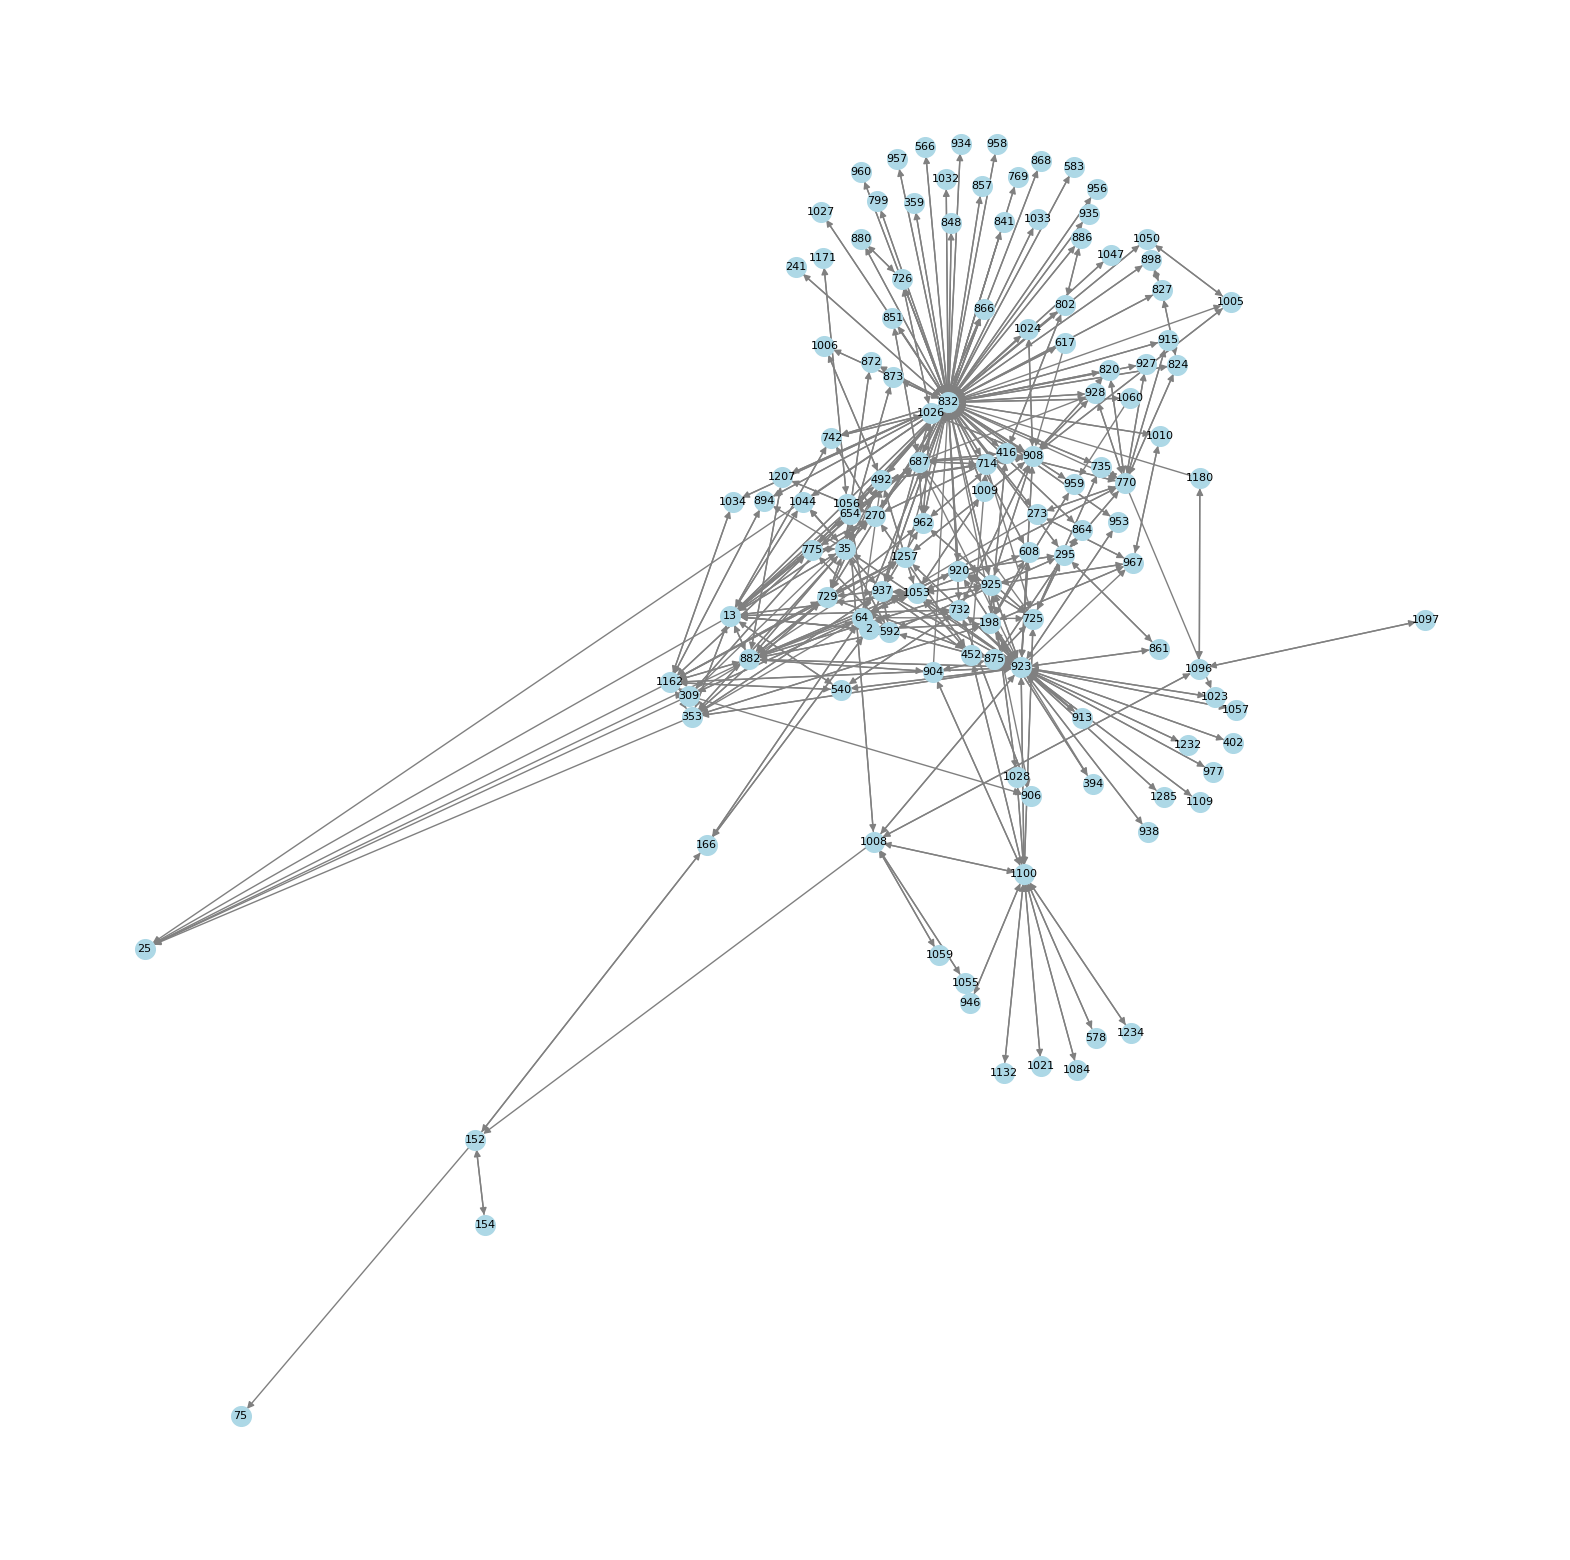

In [83]:
fig, ax = plt.subplots(figsize=(20, 20))
nx.draw(G_sub4, ax=ax, with_labels=True, node_size=200, font_size=8, node_color='lightblue', edge_color='gray', pos=nx.spring_layout(G_sub4, seed=42))

## Community detection

There are many algorithms to detect communities in networks. For an overview of the algorithms implemented in networkx, you can consult the [documentation](https://networkx.org/documentation/stable/reference/algorithms/community.html). Some popular ones are the Louvain method and the Girvan-Newman algorithm. [Tokala et al. (2025)](https://jscires.org/10.5530/jscires.20250839) give a nice overview of existing algorithms and compare their effectiveness and efficiency.

In this tutorial we will demonstrate with the Louvain method.

In [98]:
# Using the Louvain method for community detection on the subgraph
communities = nx_comm.louvain_communities(G.to_undirected(), seed=42)
# Add community ID as a node attribute
community_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_map[node] = i
nx.set_node_attributes(G_sub4, community_map, 'community')
print(f"Found {len(communities)} communities in the subgraph.")
print("\nSample communities and their members:")
for i, comm in enumerate(communities):
    print(f"Community {i}: {list(comm)[:5]}...") # Print first 5 member

Found 19 communities in the subgraph.

Sample communities and their members:
Community 0: [4102, 4111, 4117, 2070, 2073]...
Community 1: [4096, 2, 3, 7, 8]...
Community 2: [1, 4, 5, 6, 9]...
Community 3: [641, 1284, 645, 646, 1031]...
Community 4: [696, 883, 695]...
Community 5: [1088, 1089, 1078, 1079, 1080]...
Community 6: [4352, 3331, 4356, 5125, 5126]...
Community 7: [2050, 5148, 5153, 5154, 4646]...
Community 8: [2049, 4098, 4100, 4101, 4108]...
Community 9: [3076, 2055, 2061, 3090, 2067]...
Community 10: [4103, 4113, 4114, 4115, 4116]...
Community 11: [4097, 4099, 4104, 4105, 4106]...
Community 12: [3762, 3763]...
Community 13: [3912, 3911]...
Community 14: [4888, 4887]...
Community 15: [5123, 5132, 4622, 17, 5144]...
Community 16: [5665, 5666, 5668, 5669, 5631]...
Community 17: [5954, 5955, 5958, 5959, 5900]...
Community 18: [6000, 6002]...


Now we can check fraudulant behaviour in each community

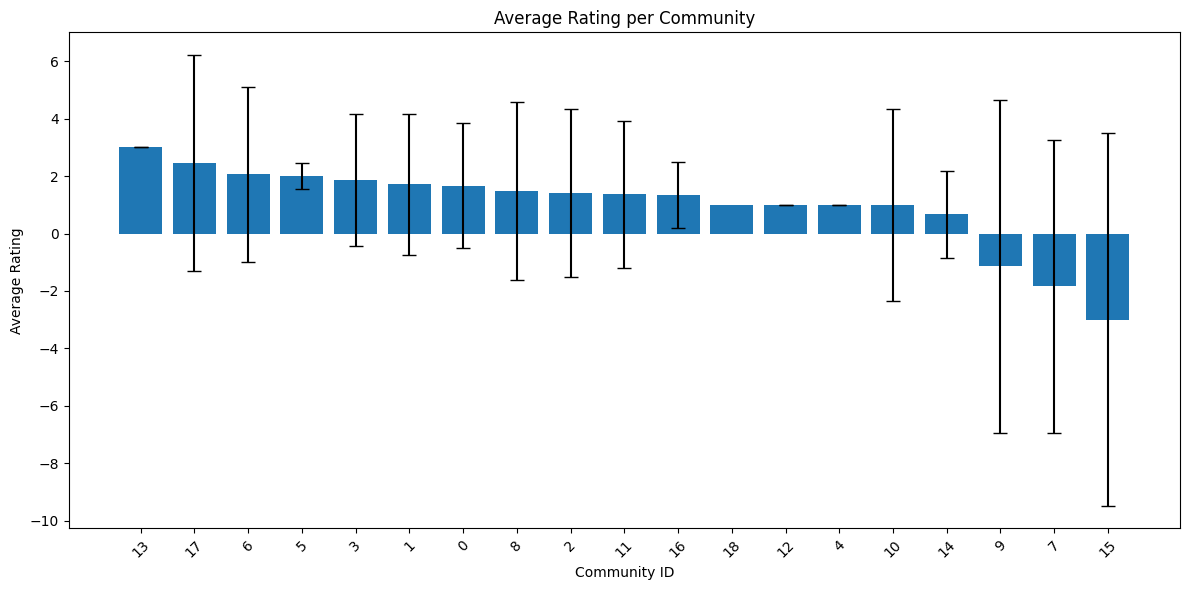

In [103]:
df = df.assign(community_id=[community_map[node] for node in df['SOURCE']])
community_ratings = df.groupby('community_id')['RATING'].agg(['mean', 'std']).reset_index()
# Filter out the 'no community' group
community_ratings = community_ratings[community_ratings['community_id'] != -1]
# Sort by mean rating for better visualization
community_ratings = community_ratings.sort_values('mean', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(
    community_ratings['community_id'].astype(str),
    community_ratings['mean'],
    yerr=community_ratings['std'],
    capsize=5
)
plt.xlabel('Community ID')
plt.ylabel('Average Rating')
plt.title('Average Rating per Community')
plt.xticks(rotation=45)
plt.tight_layout()
